In [1]:
from scipy.stats import spearmanr
import numpy as np
import pandas as pd
import sys
import os

In [38]:
# Define root directory
# root = os.path.dirname(os.path.abspath(__file__))
root = "."
sys.path.append(os.path.join(root, "..", "src"))
from default import DATAPATH, CONFIGPATH

# Load pathogen info
# pathogen_code = sys.argv[1]
pathogen_code = 'mtuberculosis'
df = pd.read_csv(os.path.join(CONFIGPATH, 'pathogens.csv'))
row = df.loc[df["code"].eq(pathogen_code)]
if row.empty: 
    raise SystemExit(f"Unknown code: {pathogen_code}")
pathogen = row.iloc[0]["pathogen"]

# Define output directory
OUTPUT = os.path.join(root, "..", "output")

# Path to correlations
PATH_TO_CORRELATIONS = os.path.join(OUTPUT, "mtuberculosis", "correlations")
STRATEGIES = ['A', 'B', 'C', 'D', "M"]

# Load data
PROBS_REF = {}
for strategy in STRATEGIES:
    PROBS_REF[strategy] = {}
    if os.path.exists(os.path.join(PATH_TO_CORRELATIONS, strategy)):
        for dataset in sorted(os.listdir(os.path.join(PATH_TO_CORRELATIONS, strategy))):
            name = dataset.replace("_ref_probs.npz", "")
            probs = np.load(os.path.join(PATH_TO_CORRELATIONS, strategy, dataset))['y_prob_ref']
            PROBS_REF[strategy][name] = probs


In [89]:
def calculate_spearman(probs1, probs2):
    return spearmanr(probs1, probs2)

def calculate_fraction_overlap(probs1, probs2, TOP=100):
    ind1 = set(np.argsort(probs1)[::-1][:TOP])
    ind2 = set(np.argsort(probs2)[::-1][:TOP])
    return len(ind1.intersection(ind2)) / len(ind1)

def overlap_chance(probs1, probs2, TOP=100):
    N = len(probs1)
    K = TOP
    ind1 = set(np.argsort(probs1)[::-1][:K])
    ind2 = set(np.argsort(probs2)[::-1][:K])
    m = len(ind1 & ind2)
    E = (K * K) / N  # expected intersection size under chance
    denom = (K - E)
    return (m - E) / denom

In [90]:
# Load data
INDIVIDUAL_LM = pd.read_csv(os.path.join(OUTPUT, pathogen_code, "individual_LM.csv"))
MERGED_LM = pd.read_csv(os.path.join(OUTPUT, pathogen_code, "merged_LM.csv"))

# Sort data and keep unique
DATASETS = {}
KEYS = ["assay_id", "activity_type", "unit"]
for LABEL in "ABCD":
    DATASETS[LABEL] = []
    df = INDIVIDUAL_LM[(INDIVIDUAL_LM[LABEL]) & 
                       (INDIVIDUAL_LM[f"{LABEL}_AVG"] > 0.7)].sort_values(f"{LABEL}_AVG", ascending=False).drop_duplicates(subset=KEYS, keep='first')
    for assay_id, activity_type, unit, expert_cutoff in df[KEYS + ['expert_cutoff']].values:
        if LABEL in "AC":
            DATASETS[LABEL].append(f"{assay_id}_{activity_type}_{unit}_qt_{expert_cutoff}")
        else:
            DATASETS[LABEL].append(f"{assay_id}_{activity_type}_{unit}_ql")

ALL_SETS = [[i,j] for i in "ABCD" for j in DATASETS[i]]

In [91]:
X = []
for i in ALL_SETS:
    X_ = []
    for j in ALL_SETS:
        label1, label2 = i[0], j[0]
        set1, set2 = i[1], j[1]
        probs1 = PROBS_REF[label1][set1]
        probs2 = PROBS_REF[label2][set2]
        a = calculate_spearman(probs1, probs2).statistic / 3
        b = overlap_chance(probs1, probs2, TOP=100) / 3
        c = overlap_chance(probs1, probs2, TOP=1_000) / 3
        X_.append(a+b+c)
    X.append(X_)

X = np.array(X)

In [106]:
import matplotlib as mpl
start_hex, end_hex = "#50285A", "#8DC7FA"
cmap = mpl.colors.LinearSegmentedColormap.from_list("two_color", [start_hex, end_hex], N=256)

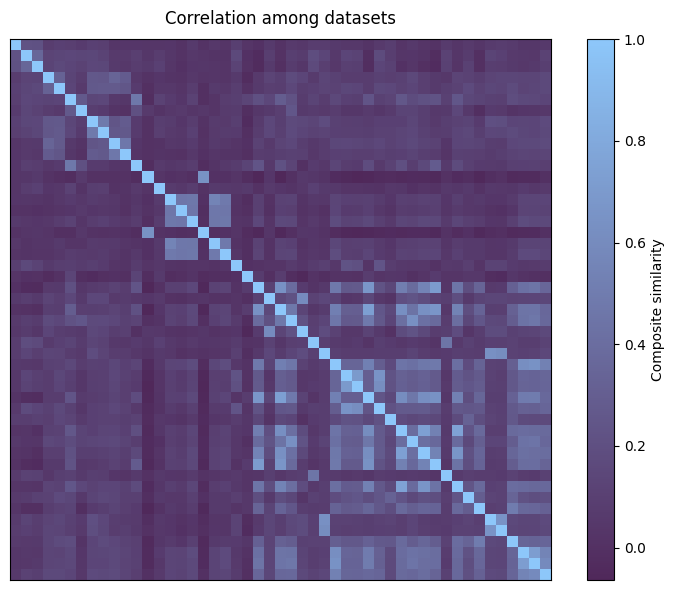

In [109]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(X, vmin=np.min(X), vmax=np.max(X), cmap=cmap)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Correlation among datasets", pad=11, size=12)
cbar = fig.colorbar(im, ax=ax, fraction=0.045)
cbar.set_label("Composite similarity")

plt.tight_layout()
plt.show()

In [95]:
ALL_SETS

[['A', 'CHEMBL1794324_AC50_umol.L-1_qt_0.5'],
 ['A', 'CHEMBL1794426_EC50_umol.L-1_qt_1.0'],
 ['A', 'CHEMBL1794349_AC50_umol.L-1_qt_5.0'],
 ['A', 'CHEMBL4649971_PERCENTEFFECT_%_qt_75.0'],
 ['A', 'CHEMBL4649961_PERCENTEFFECT_%_qt_75.0'],
 ['A', 'CHEMBL1738696_IC50_umol.L-1_qt_5.0'],
 ['A', 'CHEMBL1614183_IC50_umol.L-1_qt_5.0'],
 ['A', 'CHEMBL4649948_IC50_umol.L-1_qt_20.0'],
 ['A', 'CHEMBL4649949_IC50_umol.L-1_qt_20.0'],
 ['A', 'CHEMBL4649949_PERCENTEFFECT_%_qt_50.0'],
 ['A', 'CHEMBL4649948_PERCENTEFFECT_%_qt_25.0'],
 ['A', 'CHEMBL1738598_IC50_umol.L-1_qt_5.0'],
 ['C', 'CHEMBL4011042_GI_%_qt_75.0'],
 ['C', 'CHEMBL5246903_MIC_umol.L-1_qt_20.0'],
 ['C', 'CHEMBL1634496_MIC_umol.L-1_qt_20.0'],
 ['C', 'CHEMBL1049617_MIC_umol.L-1_qt_10.0'],
 ['C', 'CHEMBL1839642_MIC_umol.L-1_qt_20.0'],
 ['C', 'CHEMBL4011046_GI_%_qt_25.0'],
 ['C', 'CHEMBL1049618_MIC_umol.L-1_qt_20.0'],
 ['C', 'CHEMBL1634497_MIC_umol.L-1_qt_20.0'],
 ['C', 'CHEMBL3887425_IC50_umol.L-1_qt_5.0'],
 ['C', 'CHEMBL4333704_MIC_umol.L-1_q